In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
import numpy as np
import random

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc
from matplotlib import pyplot as plt

tqdm.pandas()


SEED = 254290

np.random.seed(SEED)
random.seed(SEED)

narysuj krzywe FAR,
FRR,
wyznacz EER
narysuj ROC


zmierz PSNR,
SSIM oraz BRISQUE.

In [2]:
registration_df = pd.read_csv("./data/registration.csv")
registration_df

,image,identity
0,050987.png,15
1,180629.png,97
2,108845.png,172
3,163175.png,229
4,165766.png,298
...,...,...
75,022376.png,9535
76,061873.png,9625
77,053384.png,9886
78,129996.png,10038


In [3]:
IMAGES_DIR = Path("./data/img_align_celeba_png.7z")
MODEL = "VGG-Face"

In [4]:
from users_db import UsersDB

db = UsersDB(model=MODEL)

for _, row in tqdm(registration_df.iterrows(), total=len(registration_df)):
    img_fpath = IMAGES_DIR / row["image"]
    db.add_record(row["identity"], img_fpath)

2024-04-06 19:18:57.407454: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 19:18:57.444483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 19:18:58.065793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/80 [00:00<?, ?it/s]

2024-04-06 19:18:59.180066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 19:18:59.198162: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## DF1

In [5]:
df1 = pd.read_csv("./data/df1.csv")
df1 = df1.sample(frac=0.05, random_state=SEED).reset_index(drop=True)
df1

,image,truth,identity
0,155755.png,True,4664
1,084849.png,False,1051
2,056546.png,False,6997
3,029805.png,False,2939
4,037792.png,False,9625
...,...,...,...
62,061626.png,False,7915
63,008578.png,False,4754
64,043676.png,False,2729
65,011178.png,False,5013


In [6]:
THRESHOLD_VALUES = np.linspace(0.1, 1.0, 100)

auth_history = []
for threshold in tqdm(THRESHOLD_VALUES, desc="Exp Df1 Thresholds"):
    for _, row in df1.iterrows():
        img_fpath = IMAGES_DIR / row["image"]
        distance, authorized = db.verify_user(img_fpath, row["identity"], threshold=threshold, cache=True)
        auth_history.append({
            "image": row["image"],
            "identity": row["identity"],
            "authorized": authorized,
            "truth": row["truth"],
            "distance": distance,
            "threshold": threshold,
        })


Exp Df1 Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
auth_history_df = pd.DataFrame.from_records(auth_history)
auth_history_df

,image,identity,authorized,truth,distance,threshold
0,155755.png,4664,False,True,0.629442,0.1
1,084849.png,1051,False,False,0.778809,0.1
2,056546.png,6997,False,False,0.874435,0.1
3,029805.png,2939,False,False,0.869747,0.1
4,037792.png,9625,False,False,0.848126,0.1
...,...,...,...,...,...,...
6695,061626.png,7915,True,False,0.878995,1.0
6696,008578.png,4754,True,False,0.948127,1.0
6697,043676.png,2729,True,False,0.961753,1.0
6698,011178.png,5013,True,False,0.808969,1.0


In [8]:
# Define a function to calculate FAR
def calculate_far(df, threshold):
    # Count false acceptances
    false_acceptances = df[(df['authorized'] == False) & (df['distance'] < threshold)].shape[0]
    # Get the total number of identification attempts
    total_attempts = df.shape[0]
    # Calculate FAR
    return false_acceptances / total_attempts


# Function to calculate FRR
def calculate_frr(dataframe, threshold):
    # Count false rejections
    false_rejections = dataframe[(dataframe['authorized'] == True) & (dataframe['distance'] >= threshold)].shape[0]
    # Get the total number of identification attempts by authorized users
    total_authorized_attempts = dataframe[dataframe['authorized'] == True].shape[0]
    # Calculate FRR
    if total_authorized_attempts == 0:
        return 0
    return false_rejections / total_authorized_attempts


# Function to calculate EER
def calculate_eer(far_values, frr_values, threshold_values):
    eer = 1
    eer_threshold = 0
    for far, frr, threshold in zip(far_values, frr_values, threshold_values):
        if abs(far - frr) < abs(eer - 0.5):  # Find the point where FAR and FRR are closest
            eer = (far + frr) / 2
            eer_threshold = threshold
    return eer, eer_threshold


threshold_metrics = []
for threshold in THRESHOLD_VALUES:
    threshold_metrics.append({
        "threshold": threshold,
        "far": calculate_far(auth_history_df, threshold),
        "frr": calculate_frr(auth_history_df, threshold),
    })

threshold_metrics_df = pd.DataFrame.from_records(threshold_metrics)
eer, eer_threshold = calculate_eer(threshold_metrics_df["far"].values, threshold_metrics_df["frr"].values, THRESHOLD_VALUES)

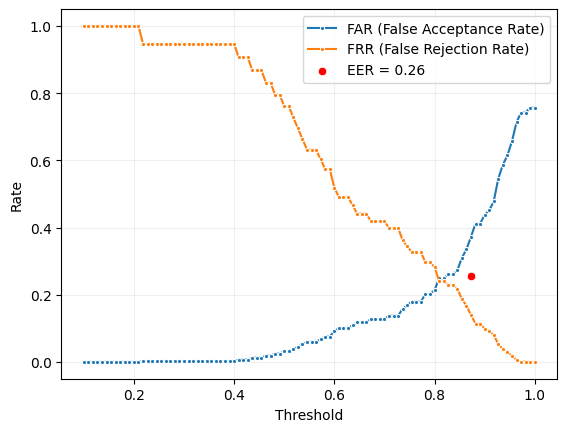

In [9]:
sns.lineplot(
    data=threshold_metrics_df,
    x="threshold",
    y="far",
    marker=".",
    label="FAR (False Acceptance Rate)",
)
sns.lineplot(
    data=threshold_metrics_df,
    x="threshold",
    y="frr",
    marker=".",
    label="FRR (False Rejection Rate)",
)
sns.scatterplot(x=[eer_threshold], y=[eer], color="red", label=f"EER = {eer:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.grid(alpha=0.2)
plt.show()

              precision    recall  f1-score   support

       False       0.93      0.70      0.80        37
        True       0.72      0.93      0.81        30

    accuracy                           0.81        67
   macro avg       0.82      0.82      0.81        67
weighted avg       0.83      0.81      0.81        67



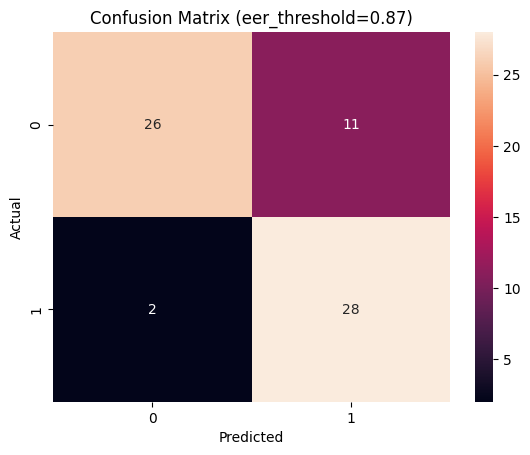

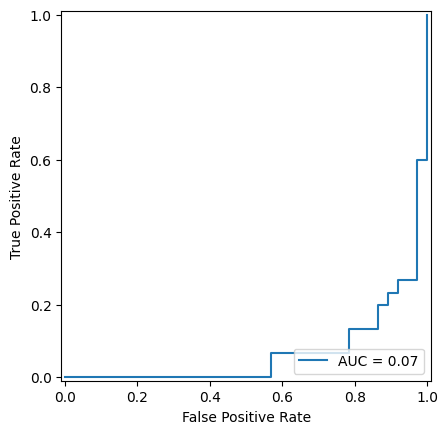

In [10]:
threshold_auth_history_df = auth_history_df[auth_history_df["threshold"] == eer_threshold]

cm = confusion_matrix(df1["truth"].values, threshold_auth_history_df["authorized"].tolist())
tn, fp, fn, tp = cm.ravel()

report = classification_report(df1["truth"].tolist(), threshold_auth_history_df["authorized"].tolist())

print(report)

sns.heatmap(cm, annot=True)
plt.title(f"Confusion Matrix ({eer_threshold=:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(df1["truth"].values, threshold_auth_history_df["distance"].values)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.show()

In [11]:
from brisque import BRISQUE


brisque = BRISQUE(url=False)